# Detective monkeys

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from pathlib import Path
import json
import plotly.graph_objs as go


In [23]:
# Loads the geojson into a JSON object
geojsonPath = Path.cwd().parent/ 'public'/'limitespdq.geojson' # You might need to change this depending on where and how you are running this code
geojson = json.load(open(geojsonPath, "r")) # The GeoJSON data contains the boundaries of the different precincts.

# Loads the criminal logs into a pandas dataframe
# You will probably need to manipulate the dataframe to get something good from it :D
criminalLogsPath = Path.cwd().parent / 'public'/'actes-criminels.csv'
df = pd.read_csv(criminalLogsPath)

In [24]:
df.head(10)

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,2017-07-21,jour,21.0,NaN,NaN,NaN,NaN
4,Méfait,2017-07-29,jour,12.0,NaN,NaN,NaN,NaN
5,Vol de véhicule à moteur,2017-07-30,nuit,21.0,NaN,NaN,NaN,NaN
6,Méfait,2017-07-30,jour,38.0,297654.715002,5.041877e+06,-73.591457,45.516776
7,Vols qualifiés,2017-07-30,jour,21.0,NaN,NaN,NaN,NaN
8,Vol dans / sur véhicule à moteur,2017-08-01,jour,39.0,294259.780993,5.051450e+06,-73.635117,45.602873
9,Méfait,2017-08-01,jour,21.0,NaN,NaN,NaN,NaN


In [25]:

mapping = df['CATEGORIE'].astype('category').cat.codes

mapping[mapping == 5]

7         5
17        5
21        5
26        5
77        5
         ..
247743    5
247752    5
247754    5
247756    5
247772    5
Length: 14156, dtype: int8

In [26]:
# Check for missing dates
df.isnull().sum()

CATEGORIE        0
DATE             0
QUART            0
PDQ              5
X            42028
Y            42028
LONGITUDE    42028
LATITUDE     42028
dtype: int64

In [27]:
quart_map = {
    'jour': 1,
    'soir': 2,
    'nuit': 3
}


df['QUART'] = df['QUART'].map(quart_map)

df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')

# Convert date to ordinal
df['DATE'] = df['DATE'].apply(lambda x: x.toordinal())

df.head()


,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,736950,1,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,736814,1,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,736938,3,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,736531,1,21.0,NaN,NaN,NaN,NaN
4,Méfait,736539,1,12.0,NaN,NaN,NaN,NaN


In [28]:
# Summarize the data
df.describe()

,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
count,247781.000000,247781.000000,247776.000000,205753.000000,2.057530e+05,205753.000000,205753.000000
mean,737040.293836,1.646987,26.309610,295794.035138,5.043223e+06,-73.615263,45.528836
std,890.410231,0.735689,14.029531,6083.008112,6.068889e+03,0.077786,0.054660
min,735599.000000,1.000000,1.000000,268109.610010,5.029291e+06,-73.968954,45.402691
25%,736251.000000,1.000000,15.000000,293900.976994,5.039088e+06,-73.639550,45.491491
50%,736974.000000,1.000000,26.000000,297338.250001,5.042868e+06,-73.595562,45.525665
75%,737848.000000,2.000000,39.000000,299665.903993,5.047185e+06,-73.565752,45.564512
max,738588.000000,3.000000,55.000000,306389.863000,5.062496e+06,-73.479583,45.702351


In [29]:

# What is the most common crime?
df['CATEGORIE'].value_counts()

Vol dans / sur véhicule à moteur    73160
Introduction                        61668
Méfait                              54323
Vol de véhicule à moteur            44244
Vols qualifiés                      14156
Infractions entrainant la mort        230
Name: CATEGORIE, dtype: int64

In [30]:
# For each PDQ and each type of crime, I want to see the number of crimes that happened in that PDQ and that type of crime

# Use pandas pivot table to create a table with the number of crimes per PDQ and per crime type

crime_freq = df.pivot_table(index='PDQ', columns='CATEGORIE', values='DATE', aggfunc='count')

crime_freq = crime_freq.fillna(0)


# Create a stacked bar chart with plotly

fig = px.bar(crime_freq, barmode='stack', width=1000, height=800)

fig.show()


In [31]:


#clean data
crime_freq = df.dropna(subset=['PDQ'])

#crime freq
crime_freq = crime_freq.groupby('PDQ').agg({'CATEGORIE': 'count'}).sort_values(by='CATEGORIE',ascending=False)
crime_freq = crime_freq.rename(columns={'CATEGORIE': 'crime_count'})

# joining to main table
combined_table = pd.merge(df, crime_freq, on="PDQ", how='inner')
crime_combined_table = combined_table.drop_duplicates(subset=['PDQ']).sort_values(by='PDQ', ascending=False)

crime_combined_table

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,crime_count
245656,Vol de véhicule à moteur,736613,2,55.0,285459.663000,5.035175e+06,-73.747285,45.456239,92
245748,Vols qualifiés,735742,2,50.0,302277.936001,5.041476e+06,-73.532280,45.513197,2028
167519,Vol dans / sur véhicule à moteur,736829,1,49.0,305817.012000,5.061471e+06,-73.486942,45.693121,6427
89104,Introduction,736545,1,48.0,302206.204009,5.050672e+06,-73.533246,45.595949,11958
183309,Vol de véhicule à moteur,736728,3,46.0,300206.969004,5.052306e+06,-73.558887,45.610645,5779
150044,Vol dans / sur véhicule à moteur,736544,1,45.0,296483.624000,5.055234e+06,-73.606674,45.636951,5310
120322,Vol dans / sur véhicule à moteur,736586,1,44.0,299537.390996,5.048547e+06,-73.567431,45.576815,9995
173946,Vol dans / sur véhicule à moteur,736727,2,42.0,298486.799994,5.048363e+06,-73.580891,45.575146,9363
55647,Vol dans / sur véhicule à moteur,736542,1,39.0,294259.780993,5.051450e+06,-73.635117,45.602873,11304
38151,Méfait,736540,1,38.0,297654.715002,5.041877e+06,-73.591457,45.516776,17496


In [32]:
## crime freq heat map code

fig = px.choropleth_mapbox(combined_table, geojson=geojson,
                           color = "crime_count", # Might need to change depending on what you want to measure
                           locations="PDQ", featureidkey="properties.PDQ",
                           center={'lat': 45.508888, 'lon': -73.561668}, # Can change the coordinates to make city more centered
                           mapbox_style="carto-positron", # Another option is called "open-street-map" :o
                           zoom=9
                           )

# .update_layout() updates the layout of the figure (includes all non-date components of the visualization)
# We are just setting the plot to take up the entire avaliable space, with no padding or spacing around the edges.
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Let's see our graph in action!
# fig.show()

In [33]:
df = pd.read_csv(criminalLogsPath)

<AxesSubplot: xlabel='PDQ'>

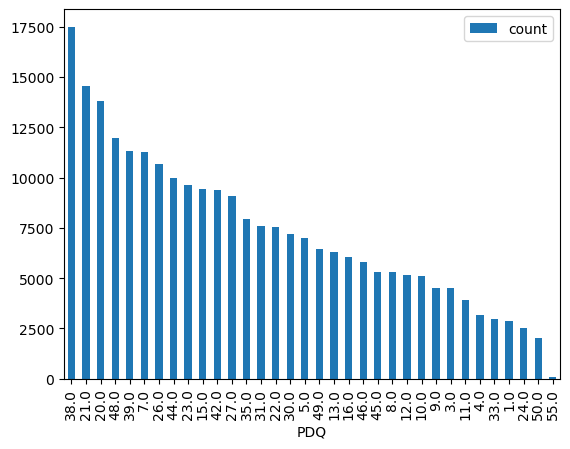

In [34]:
# Top 3 police precints (PDQ) got that most or least  crime complaints
# Group by PDQ and count the number of crimes and sort by count and list the time range of the crimes
pdq_date_df =  df.groupby('PDQ')['CATEGORIE'].agg(['count']).sort_values(by='count', ascending=False)
pdq_date_df.plot(kind = 'bar')


In [35]:
# When does the most crime happen?

# Group by time of the day (QUART) and count the number of crimes and sort by count

df.groupby('QUART')['CATEGORIE'].agg(['count']).sort_values(by='count', ascending=False)

,count
QUART,
jour,126228
soir,82795
nuit,38758


<AxesSubplot: xlabel='QUART'>

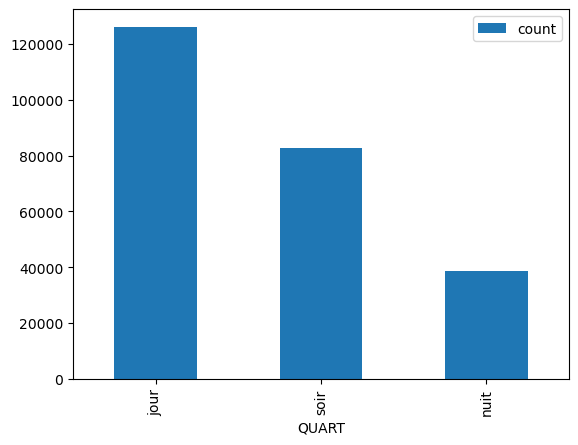

In [36]:

df.groupby('QUART')['CATEGORIE'].agg(['count']).sort_values(by='count', ascending=False).plot(kind='bar')

